In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import math
from sklearn.utils import class_weight

In [5]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [6]:
import pandas as pd

train_data['datetime'] = pd.to_datetime(train_data[['year', 'month', 'day', 'hour', 'minute']])

train_data.set_index('datetime', inplace=True)

In [7]:
test_data['datetime'] = pd.to_datetime(test_data[['year', 'month', 'day', 'hour', 'minute']])
test_data.set_index('datetime', inplace=True)


train_data.head()

,year,month,day,hour,minute,lat,lon,intensity,size,distance,Storm_NosyBe_1h,Storm_NosyBe_3h
datetime,,,,,,,,,,,,
2004-01-19 10:30:00,2004,1,19,10,30,-13.6126,48.2281,468,1422,10.44,0,1
2004-01-19 10:45:00,2004,1,19,10,45,-13.7039,48.2598,488,1881,13.34,0,1
2004-01-19 11:00:00,2004,1,19,11,0,-13.7953,48.2918,424,1746,16.28,0,1
2004-01-19 11:15:00,2004,1,19,11,15,-14.2190,48.3387,485,4167,30.41,0,1
2004-01-19 11:30:00,2004,1,19,11,30,-13.2851,49.2745,155,207,19.10,0,1


In [8]:
train_data2 = train_data.drop(columns=['year','month','day','hour','minute'])

train_data2.head()

,lat,lon,intensity,size,distance,Storm_NosyBe_1h,Storm_NosyBe_3h
datetime,,,,,,,
2004-01-19 10:30:00,-13.6126,48.2281,468,1422,10.44,0,1
2004-01-19 10:45:00,-13.7039,48.2598,488,1881,13.34,0,1
2004-01-19 11:00:00,-13.7953,48.2918,424,1746,16.28,0,1
2004-01-19 11:15:00,-14.2190,48.3387,485,4167,30.41,0,1
2004-01-19 11:30:00,-13.2851,49.2745,155,207,19.10,0,1


In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [10]:
X = train_data2[['lat', 'lon', 'intensity', 'size', 'distance']].values
y_1h = train_data2['Storm_NosyBe_1h'].values
y_3h = train_data2['Storm_NosyBe_3h'].values

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [12]:
X_seq = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

In [13]:

X_train, X_test, y_train_1h, y_test_1h = train_test_split(X_seq, y_1h, test_size=0.2, random_state=42)
X_train, X_test, y_train_3h, y_test_3h = train_test_split(X_seq, y_3h, test_size=0.2, random_state=42)

In [14]:
# Compute class weights for 3h
class_weights_3h = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_3h),
    y=y_train_3h
)
class_weights_3h = dict(enumerate(class_weights_3h))

In [15]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=input_shape))
    model.add(LSTM(32, return_sequences=False, activation='tanh'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [16]:
model_3h = build_lstm_model(X_train.shape[1:])
# Train the model for 3-hour prediction
model_3h.fit(
    X_train,             # reuse same sequences or new ones if needed
    y_train_3h,              # 3h target
    epochs=20,               # adjust as needed
    batch_size=64,           # adjust as needed
    validation_split=0.2,    # or use (X_val, y_val) explicitly
    class_weight=class_weights_3h,  # apply class weights
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5697 - loss: 0.6386 - val_accuracy: 0.7608 - val_loss: 0.5180
Epoch 2/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7258 - loss: 0.5650 - val_accuracy: 0.6428 - val_loss: 0.6250
Epoch 3/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6960 - loss: 0.5492 - val_accuracy: 0.6797 - val_loss: 0.6068
Epoch 4/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6999 - loss: 0.5482 - val_accuracy: 0.6512 - val_loss: 0.6297
Epoch 5/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7058 - loss: 0.5490 - val_accuracy: 0.7358 - val_loss: 0.5090
Epoch 6/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7124 - loss: 0.5515 - val_accuracy: 0.6918 - val_loss: 0.5732
Epoch 7/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7028 - loss: 0.5482 - val_accuracy: 0.7547 - val_loss: 0.4958
Epoch 8/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7236 - loss: 0.5468 - val_accuracy: 0.

In [17]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights for 1h
class_weights_1h = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_1h),
    y=y_train_1h
)
class_weights_1h = dict(enumerate(class_weights_1h))


In [18]:
model_1h = build_lstm_model(X_train.shape[1:])
# Train the model for 1-hour prediction
model_1h.fit(
    X_train,             # your training sequences
    y_train_1h,              # 1h target
    epochs=20,               # adjust as needed
    batch_size=64,           # adjust as needed
    validation_split=0.2,    # or use (X_val, y_val) explicitly
    class_weight=class_weights_1h,  # apply class weights
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


511/511 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7813 - loss: 0.5260 - val_accuracy: 0.7871 - val_loss: 0.4657
Epoch 2/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8088 - loss: 0.4276 - val_accuracy: 0.8249 - val_loss: 0.3947
Epoch 3/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8195 - loss: 0.4119 - val_accuracy: 0.8351 - val_loss: 0.3935
Epoch 4/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8160 - loss: 0.4095 - val_accuracy: 0.8231 - val_loss: 0.4085
Epoch 5/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8191 - loss: 0.4131 - val_accuracy: 0.8407 - val_loss: 0.3576
Epoch 6/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8241 - loss: 0.3970 - val_accuracy: 0.8400 - val_loss: 0.3691
Epoch 7/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8229 - loss: 0.4106 - val_accuracy: 0.8299 - val_loss: 0.3783
Epoch 8/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8184 - loss: 0.4058 - val_accuracy: 0.8252 - val_

In [21]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [22]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf_model_3h = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Step 1: handles class imbalance
    random_state=42
)

rf_model_3h.fit(X_train_flat, y_train_3h)  # Train on 3-hour labels


RandomForestClassifier(class_weight='balanced', random_state=42)

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Reshape the training and testing data for models that require a flat input
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


rf_model_3h = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_3h.fit(X_train_flat, y_train_3h)

rf_pred_3h = rf_model_3h.predict(X_test_flat)
rf_accuracy_3h = accuracy_score(y_test_3h, rf_pred_3h)

print("Random Forest Accuracy (3h):", rf_accuracy_3h)

Random Forest Accuracy (3h): 0.9418559122944401


In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_model_1h = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Step 1: handles imbalance
    random_state=42
)
rf_model_1h.fit(X_train_flat, y_train_1h)  # for 1h


RandomForestClassifier(class_weight='balanced', random_state=42)

In [27]:
from sklearn.ensemble import RandomForestClassifier

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

rf_model_1h = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_1h.fit(X_train_flat, y_train_1h)
rf_pred_1h = rf_model_1h.predict(X_test_flat)

print("Random Forest Accuracy (1h):", accuracy_score(y_test_1h, rf_pred_1h))

Random Forest Accuracy (1h): 0.9458692247454973


In [28]:
# For 1-hour model
scale_pos_weight_1h = len(y_train_1h[y_train_1h == 0]) / len(y_train_1h[y_train_1h == 1])

# For 3-hour model
scale_pos_weight_3h = len(y_train_3h[y_train_3h == 0]) / len(y_train_3h[y_train_3h == 1])

In [29]:
from xgboost import XGBClassifier

xgb_model_1h = XGBClassifier(
    scale_pos_weight=scale_pos_weight_1h,  # Step 1
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model_1h.fit(X_train_flat, y_train_1h)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:45:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [30]:
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb_model_3h = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model_3h.fit(X_train_flat, y_train_3h)

xgb_pred_3h = xgb_model_3h.predict(X_test_flat)
xgb_accuracy_3h = accuracy_score(y_test_3h, xgb_pred_3h)

print("XGBoost Accuracy (3h):", xgb_accuracy_3h)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:45:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy (3h): 0.9425411119812059


In [31]:
from xgboost import XGBClassifier

# Step 1: Compute class imbalance ratio
scale_pos_weight_1h = len(y_train_1h[y_train_1h == 0]) / len(y_train_1h[y_train_1h == 1])

# Define the model with imbalance handling
xgb_model_1h = XGBClassifier(
    scale_pos_weight=scale_pos_weight_1h,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train the model
xgb_model_1h.fit(X_train_flat, y_train_1h)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:45:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [32]:
from xgboost import XGBClassifier

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

xgb_model_1h = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model_1h.fit(X_train_flat, y_train_1h)
xgb_pred_1h = xgb_model_1h.predict(X_test_flat)

print("XGBoost Accuracy (1h):", accuracy_score(y_test_1h, xgb_pred_1h))

XGBoost Accuracy (1h): 0.9452819107282694


In [33]:
y_pred_1h = model_1h.predict(X_test)
y_pred_1h = (y_pred_1h > 0.7).astype(int)

y_pred_3h = model_3h.predict(X_test)
y_pred_3h = (y_pred_3h > 0.7).astype(int)

accuracy_1h = accuracy_score(y_test_1h, y_pred_1h)
accuracy_3h = accuracy_score(y_test_3h, y_pred_3h)

print(f"1 Hour Storm Prediction Accuracy: {accuracy_1h * 100:.2f}%")
print(f"3 Hour Storm Prediction Accuracy: {accuracy_3h * 100:.2f}%")

320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
1 Hour Storm Prediction Accuracy: 89.77%
3 Hour Storm Prediction Accuracy: 85.38%


In [34]:
def evaluate_model(y_true, y_pred, y_prob, model_name="Model"):
    print(f"--- {model_name} ---")
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)

    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid()
    plt.show()


320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
--- LSTM 1h ---
Confusion Matrix:


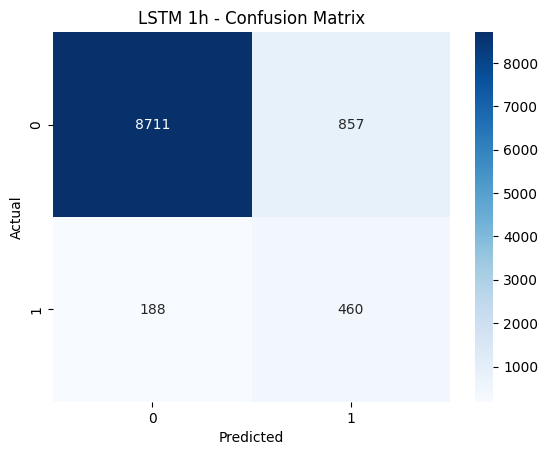

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      9568
           1       0.35      0.71      0.47       648

    accuracy                           0.90     10216
   macro avg       0.66      0.81      0.71     10216
weighted avg       0.94      0.90      0.91     10216

F1 Score: 0.4682
ROC AUC: 0.9056


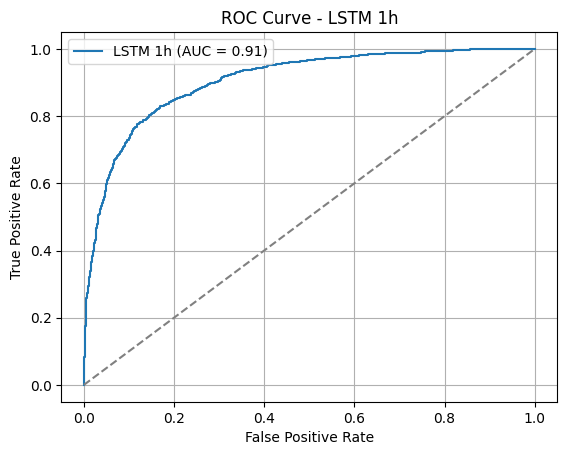

In [35]:
# Probabilities
lstm_probs = model_1h.predict(X_test).flatten()

# Binary Predictions (using 0.5 threshold)
lstm_pred_1h = (lstm_probs > 0.7).astype(int)

# Evaluate
evaluate_model(y_test_1h, lstm_pred_1h, lstm_probs, model_name="LSTM 1h")


--- Random Forest 1h ---
Confusion Matrix:


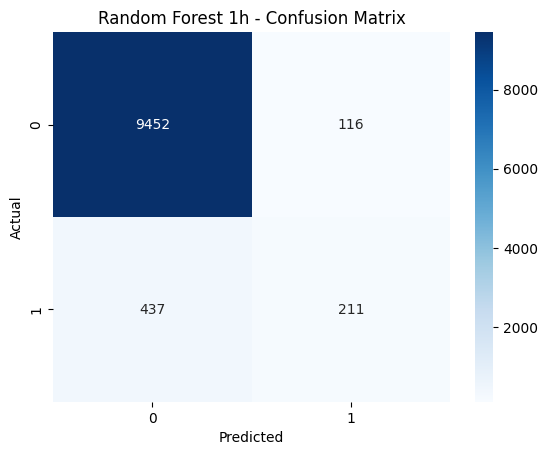

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      9568
           1       0.65      0.33      0.43       648

    accuracy                           0.95     10216
   macro avg       0.80      0.66      0.70     10216
weighted avg       0.94      0.95      0.94     10216

F1 Score: 0.4328
ROC AUC: 0.8874


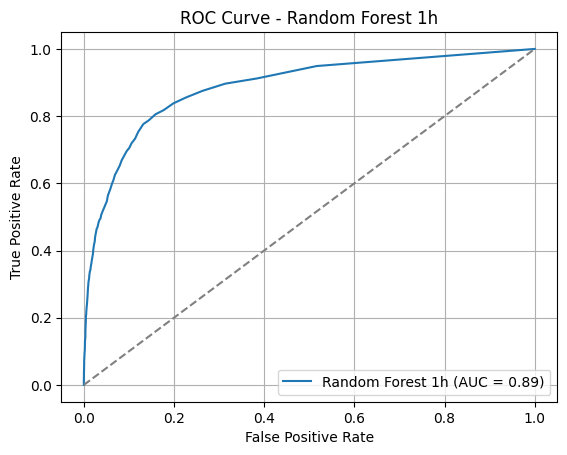

In [36]:
rf_probs = rf_model_1h.predict_proba(X_test_flat)[:, 1]
evaluate_model(y_test_1h, rf_pred_1h, rf_probs, model_name="Random Forest 1h")

--- XGBoost 1h ---
Confusion Matrix:


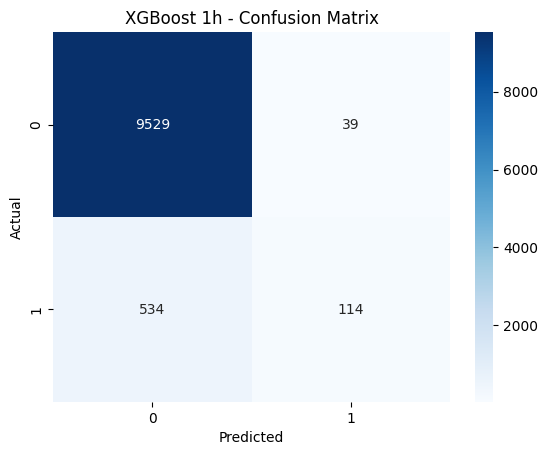

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      9568
           1       0.75      0.18      0.28       648

    accuracy                           0.94     10216
   macro avg       0.85      0.59      0.63     10216
weighted avg       0.93      0.94      0.93     10216

F1 Score: 0.2846
ROC AUC: 0.9006


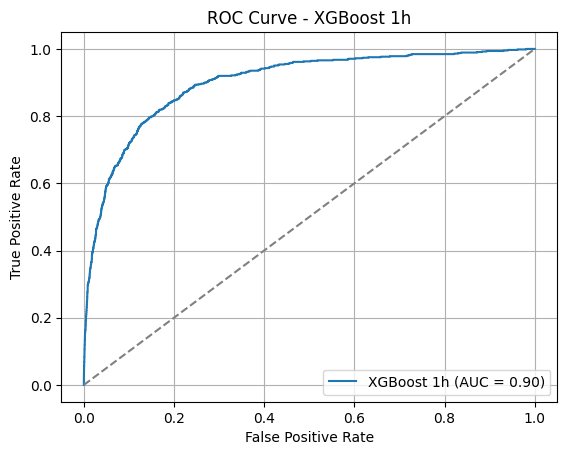

In [37]:
# Probabilities
# Replaced X_test_xgb with the correct variable name X_test_flat
xgb_probs = xgb_model_1h.predict_proba(X_test_flat)[:, 1] # XGBoost predict_proba returns probabilities directly

# Binary Predictions
xgb_pred_1h = (xgb_probs > 0.7).astype(int)


# Evaluate
evaluate_model(y_test_1h, xgb_pred_1h, xgb_probs, model_name="XGBoost 1h")

320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
--- LSTM 3h ---
Confusion Matrix:


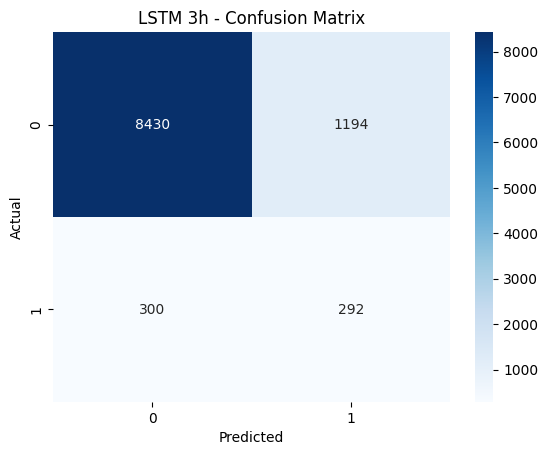

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      9624
           1       0.20      0.49      0.28       592

    accuracy                           0.85     10216
   macro avg       0.58      0.68      0.60     10216
weighted avg       0.92      0.85      0.88     10216

F1 Score: 0.2810
ROC AUC: 0.8028


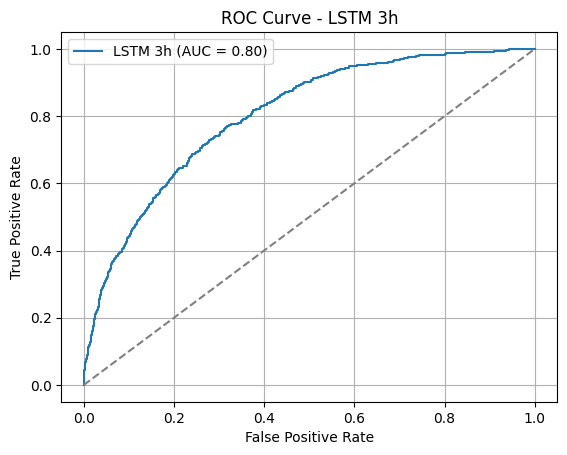

In [38]:
# Probabilities (flattened)
# Use the correct variable name X_test for the 3-hour test data
lstm_probs_3h = model_3h.predict(X_test).flatten()

# Binary predictions using threshold
lstm_pred_3h = (lstm_probs_3h > 0.7).astype(int)

# Evaluate
evaluate_model(y_test_3h, lstm_pred_3h, lstm_probs_3h, model_name="LSTM 3h")

--- Random Forest 3h ---
Confusion Matrix:


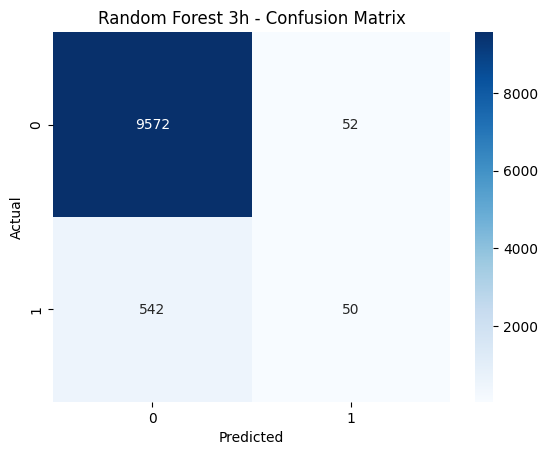

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      9624
           1       0.49      0.08      0.14       592

    accuracy                           0.94     10216
   macro avg       0.72      0.54      0.56     10216
weighted avg       0.92      0.94      0.92     10216

F1 Score: 0.1441
ROC AUC: 0.7743


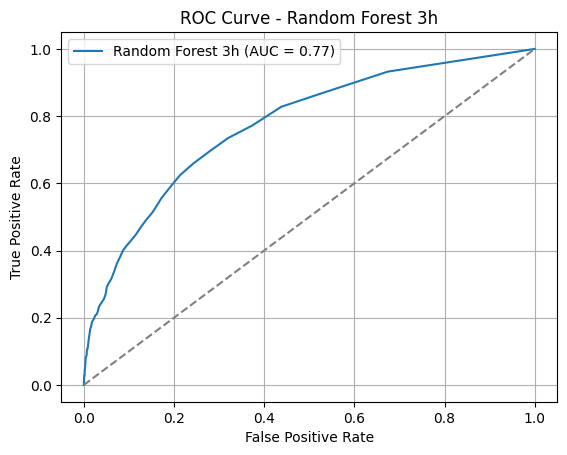

In [39]:
rf_model_3h = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_3h.fit(X_train_flat, y_train_3h)
rf_pred_3h = rf_model_3h.predict(X_test_flat)
rf_probs_3h = rf_model_3h.predict_proba(X_test_flat)[:, 1]

evaluate_model(y_test_3h, rf_pred_3h, rf_probs_3h, model_name="Random Forest 3h")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:45:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- XGBoost 3h ---
Confusion Matrix:


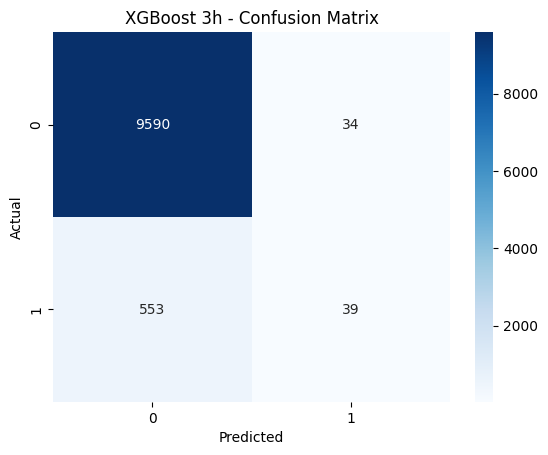

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      9624
           1       0.53      0.07      0.12       592

    accuracy                           0.94     10216
   macro avg       0.74      0.53      0.54     10216
weighted avg       0.92      0.94      0.92     10216

F1 Score: 0.1173
ROC AUC: 0.7949


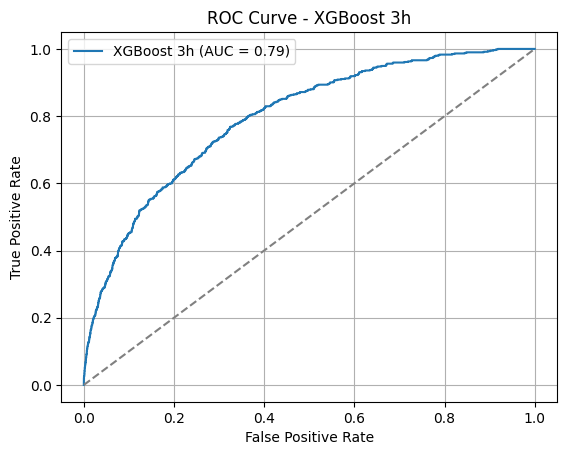

In [40]:
xgb_model_3h = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model_3h.fit(X_train_flat, y_train_3h)
xgb_pred_3h = xgb_model_3h.predict(X_test_flat)
xgb_probs_3h = xgb_model_3h.predict_proba(X_test_flat)[:, 1]


evaluate_model(y_test_3h, xgb_pred_3h, xgb_probs_3h, model_name="XGBoost 3h")


In [41]:

X_new = test_data[['lat', 'lon', 'intensity', 'size', 'distance']].values


X_new_scaled = scaler.transform(X_new)


X_new_seq = X_new_scaled.reshape(X_new_scaled.shape[0], 1, X_new_scaled.shape[1])


y_pred_prob_1h = model_1h.predict(X_new_seq)


y_pred_prob_3h = model_3h.predict(X_new_seq)


print("1 Hour Storm Prediction Probabilities:")
print(y_pred_prob_1h)

print("3 Hour Storm Prediction Probabilities:")
print(y_pred_prob_3h)

392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1 Hour Storm Prediction Probabilities:
[[0.01430201]
 [0.06451251]
 [0.02348138]
 ...
 [0.02174377]
 [0.02269197]
 [0.02799099]]
3 Hour Storm Prediction Probabilities:
[[0.01143954]
 [0.23134573]
 [0.0128602 ]
 ...
 [0.01245724]
 [0.01303194]
 [0.01354225]]


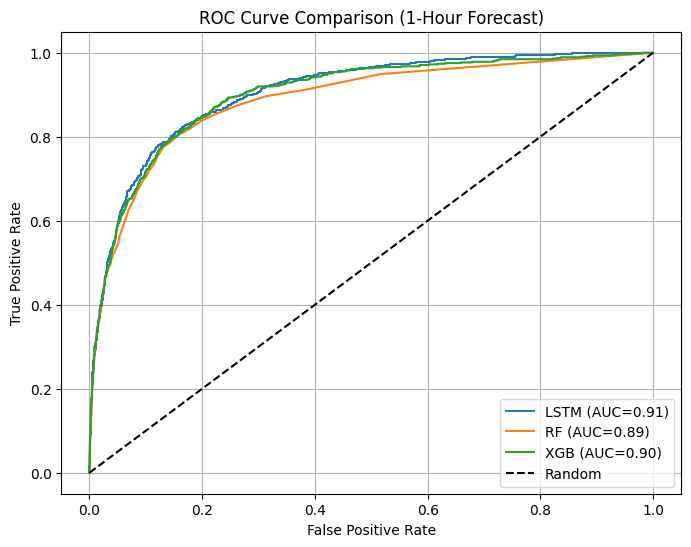

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(*roc_curve(y_test_1h, lstm_probs)[0:2], label=f"LSTM (AUC={roc_auc_score(y_test_1h, lstm_probs):.2f})")
plt.plot(*roc_curve(y_test_1h, rf_probs)[0:2], label=f"RF (AUC={roc_auc_score(y_test_1h, rf_probs):.2f})")
plt.plot(*roc_curve(y_test_1h, xgb_probs)[0:2], label=f"XGB (AUC={roc_auc_score(y_test_1h, xgb_probs):.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title("ROC Curve Comparison (1-Hour Forecast)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

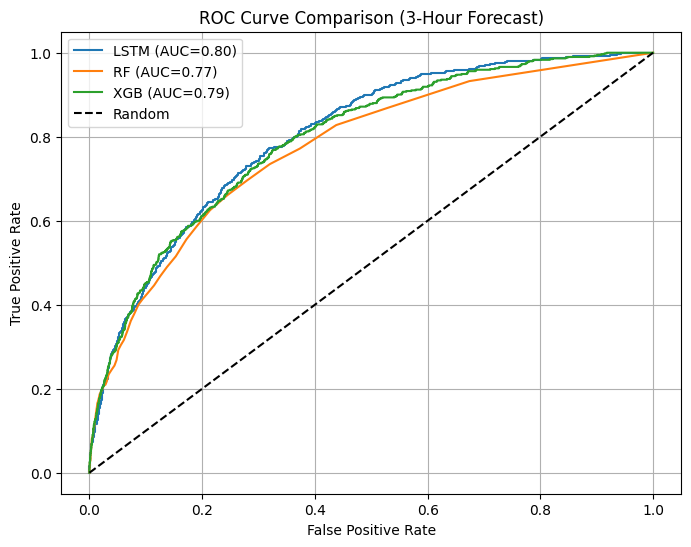

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(*roc_curve(y_test_3h, lstm_probs_3h)[0:2], label=f"LSTM (AUC={roc_auc_score(y_test_3h, lstm_probs_3h):.2f})")
plt.plot(*roc_curve(y_test_3h, rf_probs_3h)[0:2], label=f"RF (AUC={roc_auc_score(y_test_3h, rf_probs_3h):.2f})")
plt.plot(*roc_curve(y_test_3h, xgb_probs_3h)[0:2], label=f"XGB (AUC={roc_auc_score(y_test_3h, xgb_probs_3h):.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title("ROC Curve Comparison (3-Hour Forecast)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

In [44]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

# Set up cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate F1 Score
f1_scores = cross_val_score(
    rf_model_1h, X_train_flat, y_train_1h, # Use X_train_flat and y_train_1h for evaluation
    cv=skf,
    scoring=make_scorer(f1_score, average='binary')  # Use average param explicitly
)

# Evaluate ROC AUC
roc_auc_scores = cross_val_score(
    rf_model_1h, X_train_flat, y_train_1h, # Use X_train_flat and y_train_1h for evaluation
    cv=skf,
    scoring='roc_auc'  # Built-in scoring string
)

# Results
print(f"Average F1 Score: {f1_scores.mean():.4f}")
print(f"Average ROC AUC Score: {roc_auc_scores.mean():.4f}")

Average F1 Score: 0.4154
Average ROC AUC Score: 0.8835


In [45]:
import pandas as pd

storm_id = test_data['storm_id'].values

y_pred_prob_1h = y_pred_prob_1h.ravel()
y_pred_prob_3h = y_pred_prob_3h.ravel()

prediction_df = pd.DataFrame({
    'storm_id': storm_id,
    'Storm_NosyBe_1h': y_pred_prob_1h,
    'Storm_NosyBe_3h': y_pred_prob_3h
})

print(prediction_df)

prediction_df.to_csv('prediction_df111.csv', index=False)


                 storm_id  Storm_NosyBe_1h  Storm_NosyBe_3h
0      storm_202001011115         0.014302         0.011440
1      storm_202001011130         0.064513         0.231346
2      storm_202001011145         0.023481         0.012860
3      storm_202001011200         0.027513         0.012847
4      storm_202001011215         0.012623         0.019879
...                   ...              ...              ...
12527  storm_202401250530         0.514894         0.429594
12528  storm_202401250545         0.442195         0.424459
12529  storm_202401251445         0.021744         0.012457
12530  storm_202401251500         0.022692         0.013032
12531  storm_202401251515         0.027991         0.013542

[12532 rows x 3 columns]


In [49]:
import pandas as pd

# Load prediction and test datasets
predictions_df = pd.read_csv("prediction_df111.csv")
test_df = pd.read_csv("test.csv")

# Define threshold
threshold = 0.7

# Filter for 1-hour and 3-hour storm predictions
storm_1h_df = predictions_df[predictions_df["Storm_NosyBe_1h"] > threshold]
storm_3h_df = predictions_df[predictions_df["Storm_NosyBe_3h"] > threshold]

# Define the columns you want in the final output
columns_to_keep = ["storm_id", "year", "month", "day", "hour", "minute", "lat", "lon", "intensity", "size", "distance"]

# Merge filtered predictions with test data
storm_1h_merged = storm_1h_df.merge(test_df[columns_to_keep], on="storm_id", how="left")
storm_3h_merged = storm_3h_df.merge(test_df[columns_to_keep], on="storm_id", how="left")

# Keep only the specified columns in the final output
storm_1h_final = storm_1h_merged[columns_to_keep]
storm_3h_final = storm_3h_merged[columns_to_keep]

# Save to CSV
storm_1h_final.to_csv("storm_alerts_1h.csv", index=False)
storm_3h_final.to_csv("storm_alerts_3h.csv", index=False)

print("✅ Files saved: storm_alerts_1h.csv and storm_alerts_3h.csv")


✅ Files saved: storm_alerts_1h.csv and storm_alerts_3h.csv


In [ ]:
!ls

In [51]:
from google.colab import files
files.download('prediction_df111.csv')
files.download('storm_alerts_1h.csv')
files.download('storm_alerts_3h.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>